<a href="https://colab.research.google.com/github/lauxpress/NLP_UBA_Scheihing23/blob/main/NLP_Desafio_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [ ]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [ ]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [ ]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 22.2MB/s]


In [ ]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [ ]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [ ]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
df_reviews['Rating'].value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

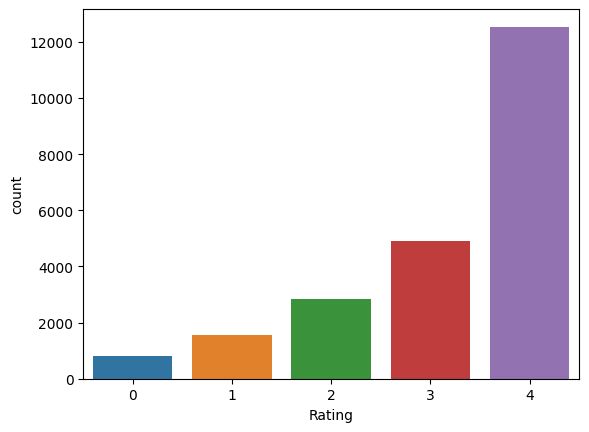

In [ ]:
# Observar como está distribuido el dataset
sns.countplot(x='Rating', data=df_reviews)
plt.show()

Notamos una distribucion muy sesgada hacia los valores mas altos de ratings.
Como uno de los requisitos del desafio es balancear el dataset, vamos a balancear el dataset

In [ ]:
min_count = 821

# Create an empty DataFrame to store the balanced data
balanced_data = pd.DataFrame()

# Iterate over unique class labels
for label in df_reviews['Rating'].unique():
    # Select samples for the current class
    samples = df_reviews[df_reviews['Rating'] == label].sample(min_count, replace=True, random_state=42)
    # Append the selected samples to the balanced data
    balanced_data = balanced_data.append(samples, ignore_index=True)

# Now 'balanced_data' contains the balanced dataset
# Shuffle the balanced dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

<ipython-input-9-458d9b1c7b4e>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_data = balanced_data.append(samples, ignore_index=True)


In [ ]:
balanced_data['Rating'].value_counts()

1    821
3    821
4    821
2    821
0    821
Name: Rating, dtype: int64

In [ ]:
balanced_data.head()

,Review Text,Rating
0,"Gorgeous color and great price, but too low cu...",1
1,I love the way the dress fit definitely a flip...,3
2,This is a lovely blouse. i think is a bit room...,3
3,"An excellent going out to dinner, to a lounge,...",4
4,I was looking forward to this cute top to get ...,2


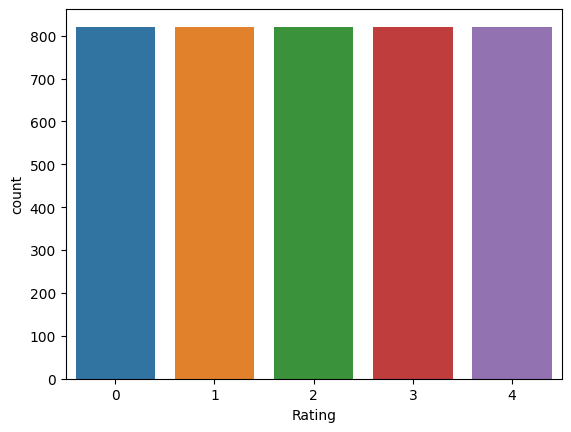

In [ ]:
# Observar como está distribuido el dataset
sns.countplot(x='Rating', data=balanced_data)
plt.show()

In [ ]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
reviews = balanced_data['Review Text'].values
reviews.shape

(4105,)

In [ ]:
# Cuantas reviews (rows) hay para evaluar?
len(reviews)

4105

In [ ]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(reviews)
corpus

'Gorgeous color and great price, but too low cut and because of the design, a cami\'s wouldn\'t work. disappointed I love the way the dress fit definitely a flip flop by the poolside bar dress. i ordered the mango colored one and was disappointed that the color resembled a dark squash orange and not as bright as it looked in picture. i think it will look nice with a tan so i will keep it. wouldn\'t plan to dress it up too much because it will definitely wrinkle ! i am a petite 5\'4 and got the regular and it fits just above my knees which is good for my taste! This is a lovely blouse. i think is a bit roomy, but even so, i like the look. i have to dress business casual for work and this blouse fits the bill as it\'s not too casual. An excellent going out to dinner, to a lounge, etc. piece. super flattering, sexy, feminine and trendy! can be dressed up or down with some nice accessories. i\'m only 5 feet and very wary of jumpsuits, but this was excellent! I was looking forward to this c

In [ ]:
# Alumno: ¿Cuál es la longitud de ese corpus?.
len(corpus)

1299436

In [ ]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [ ]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['gorgeous',
 'color',
 'and',
 'great',
 'price',
 'but',
 'too',
 'low',
 'cut',
 'and',
 'because',
 'of',
 'the',
 'design',
 'a',
 "cami's",
 "wouldn't",
 'work',
 'disappointed',
 'i']

In [ ]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

254015

In [ ]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words)
tok.fit_on_texts(tokens)

In [ ]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
print(f'tamaño de vocabulario : {len(word_index)}')
index_word = tok.index_word
print(index_word)

tamaño de vocabulario : 6605
{1: 'the', 2: 'i', 3: 'and', 4: 'it', 5: 'a', 6: 'is', 7: 'this', 8: 'to', 9: 'in', 10: 'but', 11: 'was', 12: 'on', 13: 'of', 14: 'for', 15: 'not', 16: 'so', 17: 'dress', 18: 'with', 19: 'my', 20: 'that', 21: 'very', 22: 'have', 23: 'like', 24: 'size', 25: 'top', 26: 'me', 27: 'fit', 28: 'be', 29: 'as', 30: 'too', 31: 'are', 32: 'love', 33: 'just', 34: 'would', 35: 'fabric', 36: "it's", 37: "i'm", 38: 'wear', 39: 'am', 40: 'at', 41: 'you', 42: 'small', 43: 'they', 44: 'if', 45: 'great', 46: 'or', 47: 'ordered', 48: 'really', 49: 'up', 50: 'color', 51: 'back', 52: 'look', 53: 'had', 54: 'one', 55: 'out', 56: 'more', 57: 'when', 58: 'an', 59: 'material', 60: 'because', 61: 'shirt', 62: 'all', 63: 'looks', 64: 'these', 65: '\r', 66: 'will', 67: 'cute', 68: 'much', 69: 'little', 70: 'also', 71: 'large', 72: 'which', 73: 'sweater', 74: 'well', 75: "didn't", 76: 'than', 77: 'even', 78: 'quality', 79: 'flattering', 80: 'way', 81: 'nice', 82: 'soft', 83: 'beautiful

In [ ]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(reviews)
sequences[0][:10]

[240, 50, 3, 45, 134, 10, 30, 294, 106, 3]

In [ ]:
# Alumno: Determinar cual es la oración más larga
seqs_lenght = [len(s) for s in sequences]
print(f'el máximo es {max(seqs_lenght)}')

el máximo es 110


(array([  4.,   3.,   3.,   6.,  10.,  15.,  12.,  19.,  31.,  23.,  25.,
         22.,  21.,  33.,  62.,  26.,  40.,  32.,  36.,  35.,  33.,  56.,
         38.,  46.,  43.,  33.,  43.,  37., 113.,  48.,  55.,  62.,  54.,
         44.,  36.,  48.,  57.,  53.,  53.,  39.,  34.,  45.,  99.,  52.,
         51.,  49.,  39.,  42.,  38.,  35.,  42.,  47.,  45.,  50.,  44.,
         48.,  46.,  94.,  40.,  34.,  30.,  29.,  39.,  42.,  53.,  45.,
         29.,  31.,  26.,  27.,  27.,  71.,  57.,  34.,  37.,  53.,  51.,
         40.,  43.,  53.,  45.,  61.,  78.,  73.,  67., 129.,  77.,  77.,
         53.,  45.,  45.,  27.,  19.,  16.,  12.,  18.,  10.,   5.,   3.,
          5.]),
 array([  3.  ,   4.07,   5.14,   6.21,   7.28,   8.35,   9.42,  10.49,
         11.56,  12.63,  13.7 ,  14.77,  15.84,  16.91,  17.98,  19.05,
         20.12,  21.19,  22.26,  23.33,  24.4 ,  25.47,  26.54,  27.61,
         28.68,  29.75,  30.82,  31.89,  32.96,  34.03,  35.1 ,  36.17,
         37.24,  38.31,  39.38

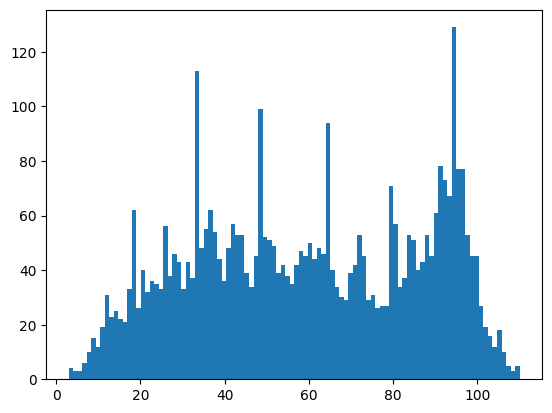

In [ ]:
plt.figure()
plt.hist(seqs_lenght,bins=100)

In [ ]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 110

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)
X

array([[   0,    0,    0, ...,  330,   97,  140],
       [   0,    0,    0, ...,   14,   19, 1525],
       [   0,    0,    0, ...,   15,   30,  274],
       ...,
       [   0,    0,    0, ...,  112,    8,  212],
       [   0,    0,    0, ...,   11,   78, 1119],
       [   0,    0,    0, ...,  342,    1,  269]], dtype=int32)

In [ ]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(4105, 110)

In [ ]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
# Aplicar one-hot encoding
y = pd.get_dummies(balanced_data['Rating'])

# Imprimir las primeras filas del resultado para verificar
print(y.head())
print(y.shape)

   0  1  2  3  4
0  0  1  0  0  0
1  0  0  0  1  0
2  0  0  0  1  0
3  0  0  0  0  1
4  0  0  1  0  0
(4105, 5)


In [ ]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [ ]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 110 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [ ]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 110
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 110, 50)           100050    
                                                                 
 lstm_2 (LSTM)               (None, 110, 64)           29440     
                                                                 
 dropout_2 (Dropout)         (None, 110, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                

In [ ]:
hist = model.fit(X_train, y_train, epochs=15, validation_split=0.2)

Epoch 1/15
83/83 [==============================] - 18s 157ms/step - loss: 1.5313 - accuracy: 0.2623 - val_loss: 1.2990 - val_accuracy: 0.3668
Epoch 2/15
83/83 [==============================] - 12s 144ms/step - loss: 1.2476 - accuracy: 0.3955 - val_loss: 1.2546 - val_accuracy: 0.3957
Epoch 3/15
83/83 [==============================] - 13s 158ms/step - loss: 1.0884 - accuracy: 0.4793 - val_loss: 1.2215 - val_accuracy: 0.4490
Epoch 4/15
83/83 [==============================] - 12s 147ms/step - loss: 0.9732 - accuracy: 0.5550 - val_loss: 1.5278 - val_accuracy: 0.3699
Epoch 5/15
83/83 [==============================] - 13s 157ms/step - loss: 0.8911 - accuracy: 0.5954 - val_loss: 1.3186 - val_accuracy: 0.4718
Epoch 6/15
83/83 [==============================] - 13s 153ms/step - loss: 0.7665 - accuracy: 0.6772 - val_loss: 1.3405 - val_accuracy: 0.5160
Epoch 7/15
83/83 [==============================] - 13s 152ms/step - loss: 0.6273 - accuracy: 0.7587 - val_loss: 1.4718 - val_accuracy: 0.5114

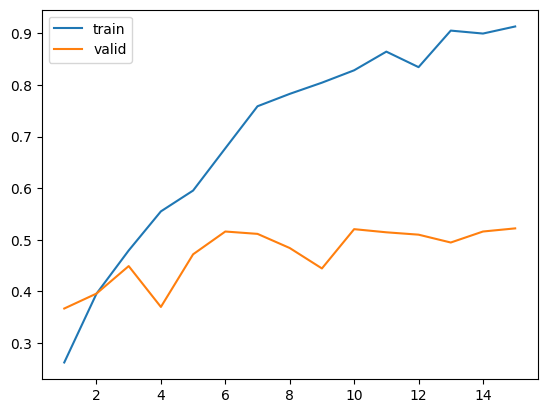

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

# Entrenemos ahora el modelo con embeddings Fasttext + LSTM

In [ ]:
#Descargamos los embeddings
!curl -L -o 'fasttext.pkl' 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2746M  100 2746M    0     0  85.3M      0  0:00:32  0:00:32 --:--:-- 80.5M


In [ ]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [ ]:
model_fasttext = FasttextEmbeddings()


In [ ]:
# Crear la Embedding matrix para la cantidad nb_words seleccionadas
# nos vamos a quedar sólo con los vectores de embeddings para las palabras
# que definimos como vocabulario

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

# word_index está ordenado de mayor a menor frecuencia de palabras
# las primeras que entren en el ciclo for serán las más frecuentes
# Atención! El tokenizador de Keras no tiene soporte para stop words
# las primeras palabras probablemente sean stopwords, para eliminarlas
# hay que procesar el word_index o bien elegir otra librería para preprocesamiento
# ¡ver clase 2! ;)
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [ ]:
# Definimos el modelo

model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                     output_dim=embed_dim, # dimensión de los embeddings utilizados
                     input_length=in_shape, # máxima sentencia de entrada
                     weights=[embedding_matrix], # matrix de embeddings
                    trainable=True)) # marcar como layer no entrenable

model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='softmax'))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 110, 300)          600000    
                                                                 
 lstm_6 (LSTM)               (None, 110, 64)           93440     
                                                                 
 dropout_6 (Dropout)         (None, 110, 64)           0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                

In [ ]:
hist2 = model2.fit(X_train, y_train, epochs=15, validation_split=0.2)

Epoch 1/15
83/83 [==============================] - 22s 265ms/step - loss: 0.8120 - accuracy: 0.6517 - val_loss: 1.3971 - val_accuracy: 0.4475
Epoch 2/15
83/83 [==============================] - 20s 245ms/step - loss: 0.6803 - accuracy: 0.7225 - val_loss: 1.4167 - val_accuracy: 0.4688
Epoch 3/15
83/83 [==============================] - 22s 261ms/step - loss: 0.5451 - accuracy: 0.7914 - val_loss: 1.5077 - val_accuracy: 0.5023
Epoch 4/15
83/83 [==============================] - 20s 237ms/step - loss: 0.4333 - accuracy: 0.8363 - val_loss: 1.5531 - val_accuracy: 0.5266
Epoch 5/15
83/83 [==============================] - 20s 239ms/step - loss: 0.3259 - accuracy: 0.8789 - val_loss: 1.9118 - val_accuracy: 0.5221
Epoch 6/15
83/83 [==============================] - 22s 272ms/step - loss: 0.2402 - accuracy: 0.9151 - val_loss: 2.1952 - val_accuracy: 0.5023
Epoch 7/15
83/83 [==============================] - 20s 242ms/step - loss: 0.1899 - accuracy: 0.9368 - val_loss: 2.2832 - val_accuracy: 0.5312

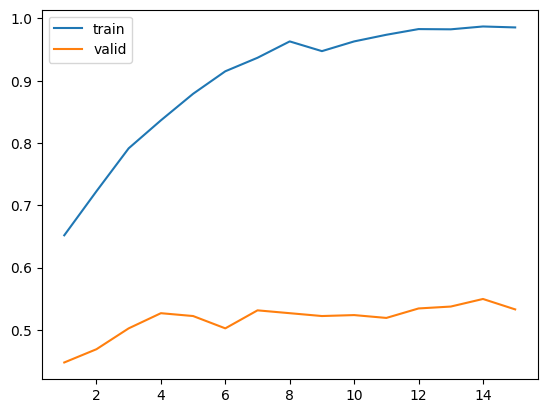

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

Ambos metodos terminan dando resultados de accuracy similares superando por poco la barrera del 0.5 y con valores muy diferentes entre el accuracy de validacion y su par.

En este caso no se notan cambios significativos entre usar el embedding generado por nosotros mismos o el de fasttext  